Bayesian Linear Regression 
===

In [8]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm as normal
from scipy.stats import invgamma
from numpy.linalg import inv 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

%matplotlib inline

gyhat=[]

#Define classifier plotting function
def plot_gaussian(xlim,ylim,mean,cov,color):
    global gyhat
    
    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(xlim[0], xlim[1],(xlim[1]-xlim[0])/100.0) ,
                           np.arange(ylim[0], ylim[1],(ylim[1]-ylim[0])/100.0))
    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx   = np.vstack((gx1l,gx2l)).T

    if(len(gyhat)==0):
        #Compute a prediction for every point in the grid
        gyhat = multivariate_normal.pdf(gx, mean=mean.flatten(), cov=cov)
        gyhat = gyhat.reshape(gx1.shape)
    
    plt.imshow(gyhat,extent=[xlim[0], xlim[1],ylim[0], ylim[1]], origin='lower')
    plt.colorbar()
    plt.axis('tight'); 

def plot_samples(Ws):
    x = np.array([[-1,1],[1,1]])
    y = x.dot(Ws.T)
    for s in range(Ws.shape[0]-1):
        plt.plot(x[:,0],y[:,s],'b-',alpha=0.05)
    plt.plot(x[:,0],y[:,-1],'b-',1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)    
    return

def plot_data(X,Y):
    plt.plot(X[:,0],Y,'k.')
    plt.xlim(-1,1)
    plt.ylim(-1,1)    
    return

def get_parameter_posterior(X,Y,sigma,tau):
    N,D = X.shape
    Sinv = X.T.dot(X)/sigma**2 + 1/(tau**2)*np.eye(D)
    S = inv(Sinv)
    m = S.dot(X.T.dot(Y))/sigma**2  
    return(m,S)

def get_likelihood(X,Y,W,sigma):
    logps = normal.logpdf(Y,X.dot(W.T),sigma)
    lik   = np.sum(logps)
    return(lik)

def get_joint(X,Y,W,sigma,P0mu,P0sigma):
    N,D = X.shape    
    
    joint = get_likelihood(X,Y,W,sigma) 
    joint += multivariate_normal.logpdf(W,P0mu.flatten(),(P0sigma**2)*np.eye(D))
    return(joint)

def mvn_sample(mu,sigma,S):
    D = mu.shape[1]
    Ws = multivariate_normal.rvs(mu.flatten(),(sigma**2)*np.eye(D),size=S)
    if(S==1):
        Ws.shape=[1,D]
    return(Ws)

def generate_data(W,N,D,Psigma):
    X      = 2*(np.random.rand(N,D)-0.5)
    X[:,1] = 1
    Y      = X.dot(W.T)+Psigma*np.random.randn(N,1)
    return(X,Y)


def MHStep(W,X,Y,Qmu,Qsigma,P0mu,P0sigma,Psigma):
    Wnew     = mvn_sample(W+Qmu,Qsigma,1)
    logPW    = get_joint(X,Y,W,Psigma,P0mu,P0sigma)
    logPWnew = get_joint(X,Y,Wnew,Psigma,P0mu,P0sigma)
    if(np.exp(logPWnew-logPW)>np.random.rand()):
        return(Wnew,1,logPWnew)
    else:
        return(W,0,logPW)
    


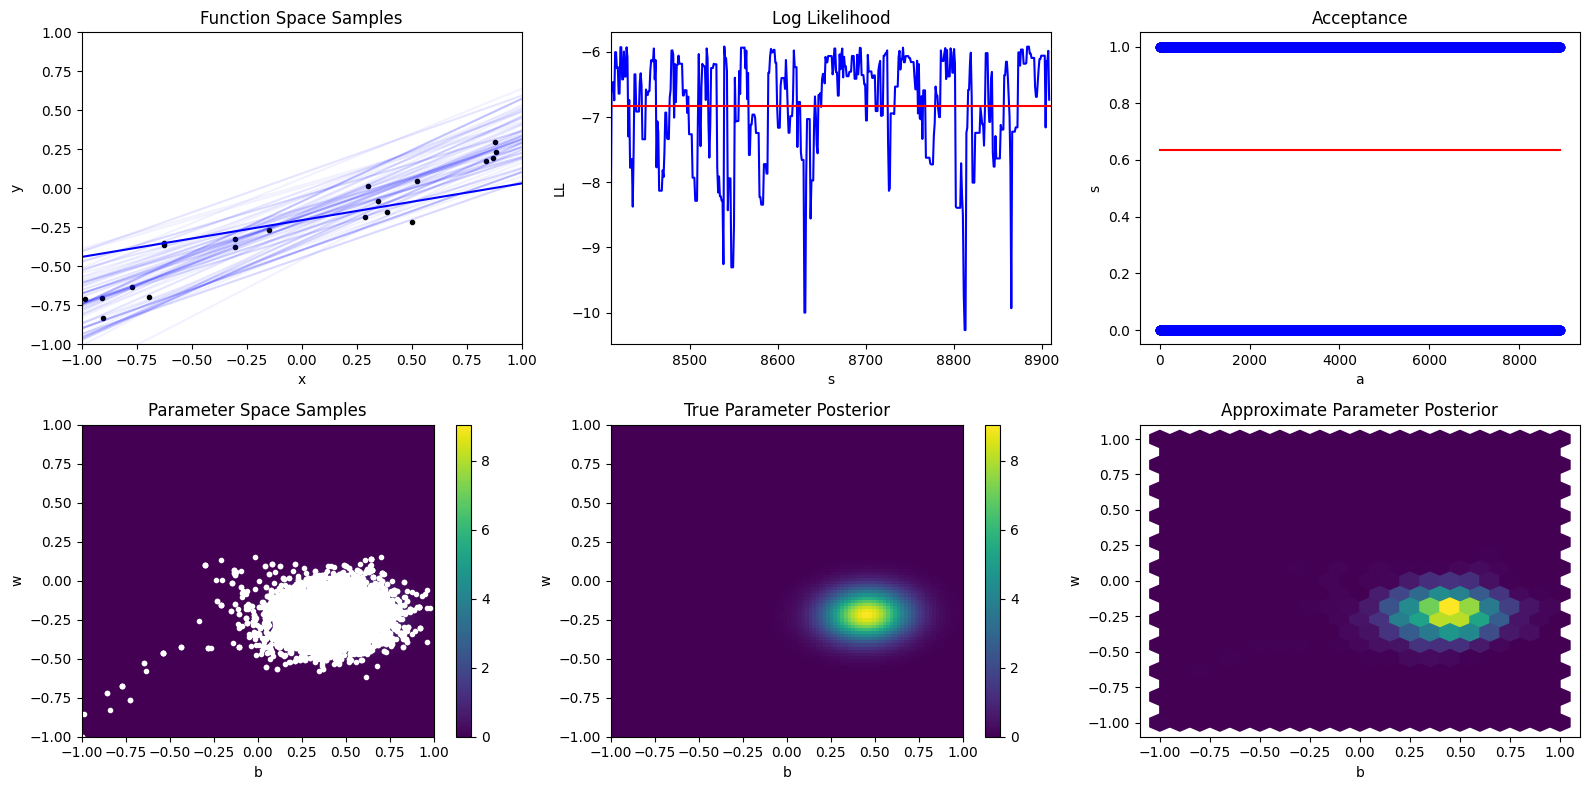

In [9]:
#Number of dimensions (including bias absorbtion)
D      = 2
N      = 20
skip   = 10

show_wsview = True
show_lik    = True
show_acc    = True

#Define proposal distribution parameters
Qmu    = np.zeros((1,D))
Qsigma = 0.1

#Define prior distribution parameters
P0mu   = np.zeros((1,D))
P0sigma= 0.5

#Define likelihood parameters and generate data
Psigma = 0.5
Wtrue  = np.array([[0.5,-0.25]])
X,Y    = generate_data(Wtrue,N,D,0.1)

S=10000
A  = np.zeros((S,)) 
Ws = np.zeros((S,D))
logPW = -np.inf*np.ones((S,))
Ws[0,:] = mvn_sample(P0mu,P0sigma,1)
Ws[0,0] = -1
Ws[0,1] = -1

gyhat=[]
Postm,PostS = get_parameter_posterior(X,Y,Psigma,P0sigma)    

Ws[0,:],A[0],logPW[0] = MHStep(Ws[[0],:],X,Y,Qmu,Qsigma,P0mu,P0sigma,Psigma)

for s in range(1,S):
    try:
        Ws[s,:],A[s],logPW[s] = MHStep(Ws[[s-1],:],X,Y,Qmu,Qsigma,P0mu,P0sigma,Psigma)

        if(s%skip==0 and s>1):
            plt.figure(1,figsize=[16,8])
            plt.subplot(2,3,1)
            plot_data(X,Y)
            plot_samples(Ws[max(0,s-100):s])
            plt.title("Function Space Samples")
            plt.xlabel("x")
            plt.ylabel("y")

            if(show_lik):
                plt.subplot(2,3,2)
                plt.plot(logPW[1:s],'b-')
                plt.plot([0,S],[np.mean(logPW[max(1,s-500):s]),np.mean(logPW[max(1,s-500):s])],'r-')  
                plt.xlim(max(0,s-500),max(s,500))
                minll = np.min(logPW[max(0,s-500):s])
                maxll = np.max(logPW[max(0,s-500):s])
                deltall = np.abs(maxll-minll)
                plt.ylim(minll-0.05*deltall, maxll+0.05*deltall)
                plt.title("Log Likelihood")
                plt.xlabel("s")
                plt.ylabel("LL")

            if(show_acc):    
                plt.subplot(2,3,3)
                plt.plot(A[1:s],'bo')
                plt.plot([0,s],[np.mean(A[1:s]),np.mean(A[1:s])],'r-')    
                plt.title("Acceptance")
                plt.xlabel("a")
                plt.ylabel("s")

            if(show_wsview):
                plt.subplot(2,3,4)
                plot_gaussian([-1,1],[-1,1],Postm,PostS,'b')
                plt.plot(Wtrue[0,0],Wtrue[0,1],'r*')
                plt.plot(Ws[s,0],Ws[s,1],'wo')
                plt.plot(Ws[s-1:s+1,0],Ws[s-1:s+1,1],'w.-')
                plt.plot(Ws[:s-1,0],Ws[:s-1,1],'w.')
                plt.title("Parameter Space Samples")
                plt.xlabel('b')
                plt.ylabel('w')

                plt.subplot(2,3,5)
                plot_gaussian([-1,1],[-1,1],Postm,PostS,'b')
                plt.title("True Parameter Posterior")
                plt.xlabel('b')
                plt.ylabel('w')

                plt.subplot(2,3,6)
                plt.hexbin(Ws[:s+1,0], Ws[:s+1,1], gridsize=20, extent=[-1,1,-1,1])
                plt.title("Approximate Parameter Posterior")
                plt.xlabel('b')
                plt.ylabel('w')


            clear_output(wait=True)
            plt.tight_layout()
            plt.show()
    except:
        break

    
